In [1]:
pip install requests beautifulsoup4 robustbase


Defaulting to user installation because normal site-packages is not writeable
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/587.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/587.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/587.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/587.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/587.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/587.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/587.4 kB ? eta -:--:--
   ----------------- ---------------------- 262.1/587.4 kB ? eta -:--:--
   ----------------- -

In [3]:
import requests
from bs4 import BeautifulSoup
from sklearn.covariance import MinCovDet
from scipy.stats import chi2
import numpy as np
from sklearn.preprocessing import MinMaxScaler



In [ ]:
import pandas as pd
import re

# Load the CSV file
df = pd.read_csv("B:/tut-pricing-model\Makeup Essentials Scrape - Copy of Sheet1.csv", encoding="utf-8")

# Drop rows where Price is missing
df = df.dropna(subset=["Price"])

# Function to clean price values
def clean_price(price_str):
    if price_str is None:
        return None
    numeric_str = re.sub(r"[^\d\.]", "", str(price_str))
    try:
        return float(numeric_str)
    except ValueError:
        return None

# Apply price cleaning
df["price_numeric"] = df["Price"].apply(clean_price)

# Remove duplicates based on product name and cleaned price
def remove_duplicates_by_name_and_price(df):
    df = df.sort_values(by=["Product Name", "price_numeric"])
    df = df.drop_duplicates(subset=["Product Name", "price_numeric"], keep="first")
    return df

df = remove_duplicates_by_name_and_price(df)


df_lipstick = df[df["Product type"].str.lower() == "lipstick"]


# Display the resulting filtered DataFrame
print(df_lipstick)


      Unnamed: 0 Website  Product type  \
2441         NaN     Noon     Lipstick   
2403         NaN     Noon     Lipstick   
2371         NaN     Noon     Lipstick   
3832         NaN  Sephora     Lipstick   
3811         NaN  Sephora     Lipstick   
...          ...      ...          ...   
1028         NaN   Amazon     Lipstick   
1029         NaN   Amazon     Lipstick   
991          NaN   Amazon     Lipstick   
1058         NaN   Amazon     Lipstick   
990          NaN   Amazon     Lipstick   

                                          Product Link   \
2441  https://www.noon.com/saudi-en/a-set-long-lasti...   
2403  https://www.noon.com/saudi-en/a-set-of-6-long-...   
2371  https://www.noon.com/saudi-en/mini-meet-matt-l...   
3832  https://www.sephora.me/sa-en/p/lip-velvet/P100...   
3811  https://www.sephora.me/sa-en/p/matte-and-satin...   
...                                                 ...   
1028  https://www.amazon.sa/-/en/Catsuit-High-Shine-...   
1029  https://www.amazo

<>:5: SyntaxWarning: invalid escape sequence '\M'
<>:5: SyntaxWarning: invalid escape sequence '\M'
C:\Users\Basmala Kamal\AppData\Local\Temp\ipykernel_24736\3705554031.py:5: SyntaxWarning: invalid escape sequence '\M'
  df = pd.read_csv("B:/tut-pricing-model\Makeup Essentials Scrape - Copy of Sheet1.csv", encoding="utf-8")


In [6]:
def is_multi_item(title):
    title = title.lower()

    # Case 1: 'Set' and 'Pieces'
    if "set" in title and "pieces" in title or "bundle" in title or "pack" in title:
        return True

    # Case 2: '2-pack', 'two-pack', '2 bottles', 'two bottles'
    if re.search(r'(2-pack|two-pack|2 bottles|two bottles|two items|two)', title, re.IGNORECASE):
        return True

    # Case 3: '3 bottles', '4 pack', '5 count', etc.
    if re.search(r'\b\d+\s*(?:bottles|packs?|count)\b', title, re.IGNORECASE):
        return True

    return False

# Create a mask for sets
mask_sets = df_lipstick["Product Name"].apply(is_multi_item)

# Split the DataFrame
sets_df_lipstick = df_lipstick[mask_sets].copy()
df_lipstick = df_lipstick[~mask_sets].copy()

# Optional: Reset index if needed
sets_df_lipstick.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [7]:
print(df_lipstick["price_numeric"].describe())


count    1496.000000
mean       69.908309
std        55.038602
min         7.340000
25%        35.300000
50%        51.750000
75%        83.410000
max       471.000000
Name: price_numeric, dtype: float64


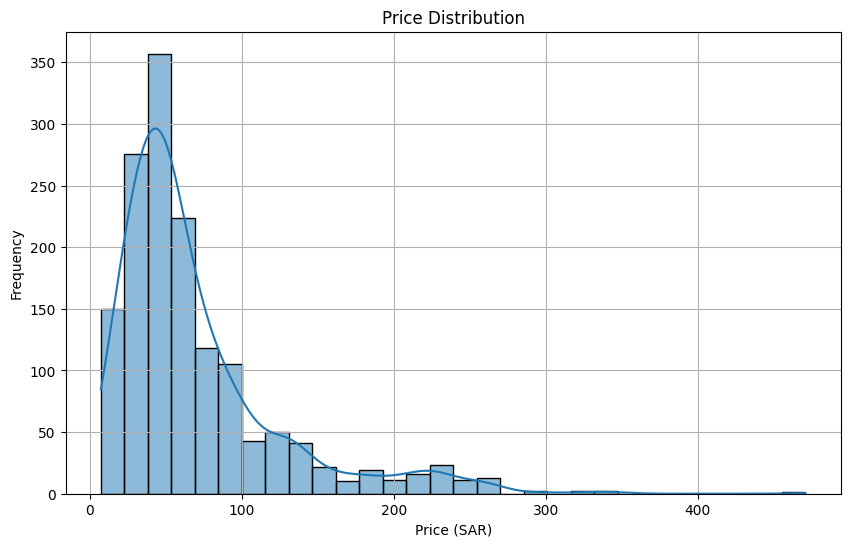

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_lipstick["price_numeric"].dropna(), bins=30, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price (SAR)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [11]:
df_lipstick_cleaned = df_lipstick.dropna(subset=["Product Name", "price_numeric"])
df_lipstick_cleaned.shape

(1496, 8)

In [12]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Apply log transformation to the cleaned numeric price column
df_lipstick_cleaned["price_log"] = np.log1p(df_lipstick["price_numeric"])

# Then apply standard scaling
scaler = StandardScaler()
df_lipstick_cleaned["price_scaled"] = scaler.fit_transform(df_lipstick_cleaned[["price_log"]])


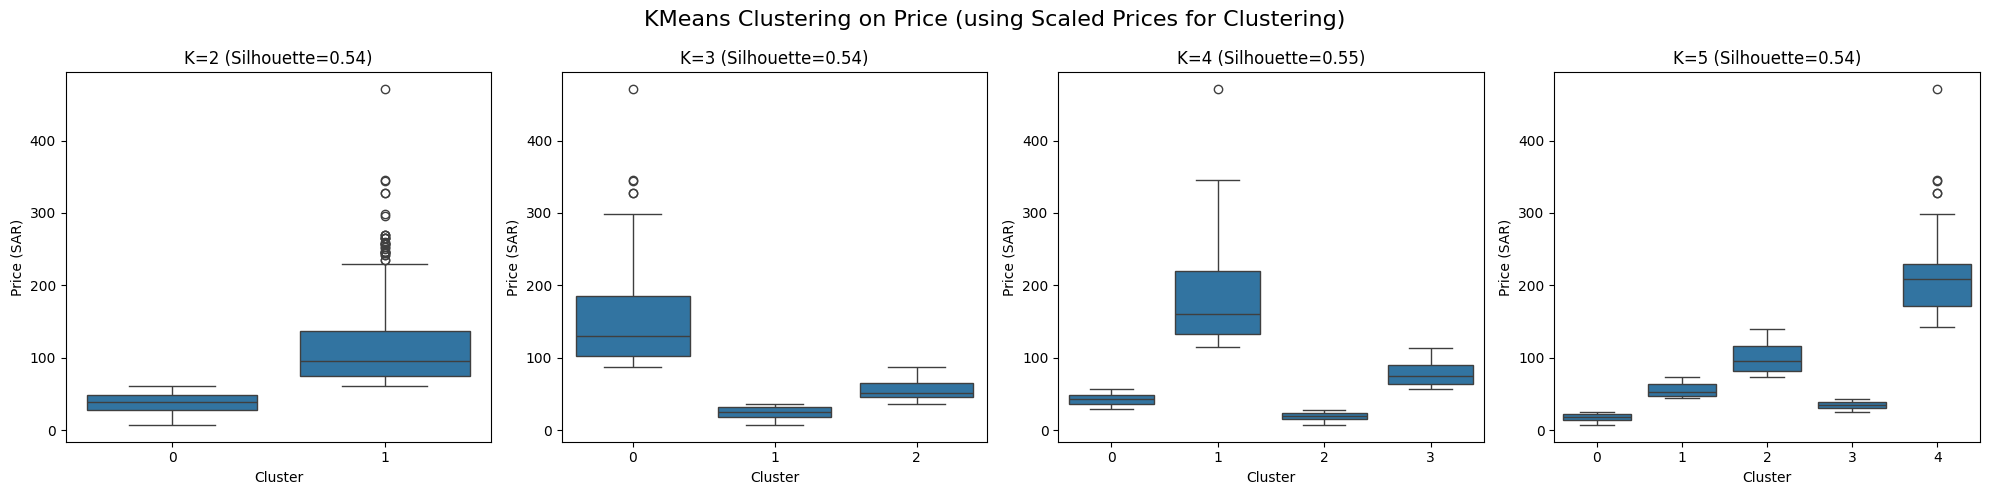

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


# 2. Feature for clustering
X_price = df_lipstick_cleaned[["price_scaled"]].values

# 3. Plot setup
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 4. Try multiple cluster counts
for idx, k in enumerate([2, 3, 4, 5]):
    if len(df_lipstick_cleaned) < k:
        print(f"Skipping k={k} due to insufficient data.")
        continue

    # Fit KMeans
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X_price)

    # Add cluster labels to DataFrame
    cluster_col = f"cluster_k{k}"
    df_lipstick_cleaned[cluster_col] = kmeans.labels_

    # Silhouette score
    if len(set(kmeans.labels_)) > 1:
        sil_score = silhouette_score(X_price, kmeans.labels_)
    else:
        sil_score = np.nan

    # Boxplot using raw prices, grouped by cluster
    sns.boxplot(
        x=cluster_col,
        y="price_numeric",  # Show real prices
        data=df_lipstick_cleaned,
        ax=axes[idx]
    )
    axes[idx].set_title(f"K={k} (Silhouette={sil_score:.2f})")
    axes[idx].set_xlabel("Cluster")
    axes[idx].set_ylabel("Price (SAR)")

# Final plot formatting
plt.suptitle("KMeans Clustering on Price (using Scaled Prices for Clustering)", fontsize=16)
plt.tight_layout()
plt.show()


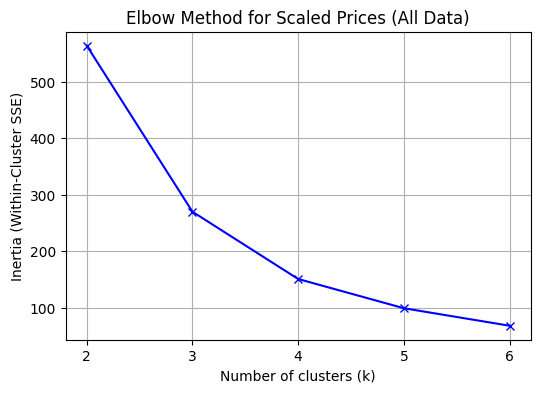

In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Extract scaled price for clustering
X_price = df_lipstick_cleaned[["price_scaled"]].values

# Elbow Method: Try k from 2 to 5
distortions = []
K_range = range(2, 7)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X_price)
    distortions.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(6, 4))
plt.plot(K_range, distortions, 'bx-')
plt.title('Elbow Method for Scaled Prices (All Data)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-Cluster SSE)')
plt.xticks(K_range)
plt.grid(True)
plt.show()


In [16]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# 1. Extract price_scaled values for clustering
X_price = df_lipstick_cleaned[["price_scaled"]].values

# 2. Run KMeans with k=3
k = 3
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(X_price)

# 3. Assign cluster labels back to df_cleaned
df_lipstick_cleaned= df_lipstick_cleaned.copy()  # optional: avoid modifying original
df_lipstick_cleaned["final_cluster"] = kmeans.labels_

# 4. Show actual price statistics per cluster
summary = (
    df_lipstick_cleaned
    .groupby("final_cluster")["price_numeric"]
    .agg(["count", "mean", "min", "max"])
    .sort_index()
)

print("Cluster Summary Based on Actual Prices (SAR):")
print(summary)


Cluster Summary Based on Actual Prices (SAR):
               count        mean    min     max
final_cluster                                  
0                346  150.564306  88.00  471.00
1                383   24.711305   7.34   35.75
2                767   56.092764  36.00   87.80


In [17]:
low = df_lipstick_cleaned[
    (df_lipstick_cleaned["final_cluster"] == 0)
]
low

,Unnamed: 0,Website,Product type,Product Link,Product Img,Product Name,Price,price_numeric,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
3832,NaN,Sephora,Lipstick,https://www.sephora.me/sa-en/p/lip-velvet/P100...,https://img-product.sephora.me/dw/image/v2/BKW...,ANASTASIA BEVERLY HILLS Lip Velvet,120.00,120.00,4.795791,1.139666,1,0,1,2,0
3811,NaN,Sephora,Lipstick,https://www.sephora.me/sa-en/p/matte-and-satin...,https://img-product.sephora.me/dw/image/v2/BKW...,ANASTASIA BEVERLY HILLS Matte and Satin Lipstick,108.00,108.00,4.691348,0.985268,1,0,3,2,0
3918,NaN,Sephora,Lipstick,https://www.sephora.me/sa-en/p/velvet-lip-duo/...,https://img-product.sephora.me/dw/image/v2/BKW...,ANASTASIA BEVERLY HILLS Velvet Lip Duo,100.00,100.00,4.615121,0.872580,1,0,3,2,0
3941,NaN,Sephora,Lipstick,https://www.sephora.me/sa-en/p/ecstasy-mirror-...,https://img-product.sephora.me/dw/image/v2/BKW...,ARMANI Ecstasy Mirror - Mirror Shine Lip Gloss,202.00,202.00,5.313206,1.904565,1,0,1,4,0
3886,NaN,Sephora,Lipstick,https://www.sephora.me/sa-en/p/lip-maestro-sat...,https://img-product.sephora.me/dw/image/v2/BKW...,ARMANI Lip Maestro Satin Liquid Lipstick,225.00,225.00,5.420535,2.063230,1,0,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1420,NaN,Amazon,Lipstick,https://www.amazon.sa/-/en/theBalm-Meet-Matt-H...,https://m.media-amazon.com/images/I/61HitrGv+f...,theBalm Meet Matt(e) Hughes 3-pc Lip Kit,178,178.00,5.187386,1.718564,1,0,1,4,0
1378,NaN,Amazon,Lipstick,https://www.amazon.sa/-/en/theBalm-Meet-Matte-...,https://m.media-amazon.com/images/I/616OdMzvjK...,"theBalm Meet Matte Hughes - Generous, 0.25 fl....",110.28,110.28,4.712050,1.015871,1,0,3,2,0
1380,NaN,Amazon,Lipstick,https://www.amazon.sa/-/en/theBalm-Hughes-Last...,https://m.media-amazon.com/images/I/61Uxy0R0n9...,theBalm the Balm Meet Matte Hughes Long Lastin...,112.94,112.94,4.735672,1.050792,1,0,3,2,0
1263,NaN,Amazon,Lipstick,https://www.amazon.sa/-/en/Halloween-Fantasy-M...,https://m.media-amazon.com/images/I/71dQkzSCh2...,wet n wild Halloween Fantasy Makers Mega Last ...,98,98.00,4.595120,0.843013,1,0,3,2,0


In [18]:
mid = df_lipstick_cleaned[
    (df_lipstick_cleaned["final_cluster"] == 1)
]
mid

,Unnamed: 0,Website,Product type,Product Link,Product Img,Product Name,Price,price_numeric,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
2441,NaN,Noon,Lipstick,https://www.noon.com/saudi-en/a-set-long-lasti...,https://f.nooncdn.com/p/pzsku/Z04554BBE69F95A7...,AMYTIS GARDEN A set long lasting lipsticks in...,32.4,32.40,3.508556,-0.763263,0,1,0,3,1
2403,NaN,Noon,Lipstick,https://www.noon.com/saudi-en/a-set-of-6-long-...,https://f.nooncdn.com/p/pzsku/Z4D5004E6C01BE7B...,AMYTIS GARDEN A set of 6 long-lasting lipstick...,32.4,32.40,3.508556,-0.763263,0,1,0,3,1
2319,NaN,Noon,Lipstick,https://www.noon.com/saudi-en/color-lipstick-c...,https://f.nooncdn.com/p/pzsku/Z27B445510531C1A...,BOLAND LAURA COLOR LIPSTICK COLLECTION,21.8,21.80,3.126761,-1.327674,0,1,2,0,1
2462,NaN,Noon,Lipstick,https://www.noon.com/saudi-en/matte-liquid-lip...,NaN,BOLVER Matte Liquid Lipstick 930,26.95,26.95,3.330417,-1.026607,0,1,2,3,1
2337,NaN,Noon,Lipstick,https://www.noon.com/saudi-en/10-pcs-matte-liq...,https://f.nooncdn.com/p/pzsku/ZE3F98A5862833A0...,CAKAILA 10 Pcs Matte Liquid Lipstick Set Conta...,32,32.00,3.496508,-0.781074,0,1,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2522,NaN,Noon,Lipstick,https://www.noon.com/saudi-en/instyle-extreme-...,NaN,topface Instyle Extreme Matte Lip Paint Cashmere,21.1,21.10,3.095578,-1.373772,0,1,2,0,1
999,NaN,Amazon,Lipstick,https://www.amazon.sa/-/en/Cream-Cloud-Marshma...,https://m.media-amazon.com/images/I/71dWpLxxLs...,"wet n wild Lip Cream Cloud Pout w/Marshmallow,...",22,22.00,3.135494,-1.314763,0,1,2,0,1
1001,NaN,Amazon,Lipstick,https://www.amazon.sa/-/en/Markwins-Marshmallo...,https://m.media-amazon.com/images/I/712JCK-Re0...,"wet n wild Markwins, Cloud Pout Marshmallow Li...",24.55,24.55,3.240637,-1.159329,0,1,2,0,1
1028,NaN,Amazon,Lipstick,https://www.amazon.sa/-/en/Catsuit-High-Shine-...,https://m.media-amazon.com/images/I/71pxgzUKqF...,wet n wild Mega Last Catsuit High-Shine Liquid...,33.63,33.63,3.544720,-0.709801,0,1,0,3,1


In [19]:
high = df_lipstick_cleaned[
    (df_lipstick_cleaned["final_cluster"] == 2)
]
high

,Unnamed: 0,Website,Product type,Product Link,Product Img,Product Name,Price,price_numeric,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
2371,NaN,Noon,Lipstick,https://www.noon.com/saudi-en/mini-meet-matt-l...,https://f.nooncdn.com/p/pzsku/ZEEAA4DFC6DB2C06...,AMYTIS GARDEN Mini Meet Matt Liquid Lipstick S...,40.5,40.50,3.725693,-0.442267,0,2,0,3,2
2688,NaN,Noon,Lipstick,https://www.noon.com/saudi-en/avon-power-stay-...,NaN,AVON AVON Power Stay Liquid Lip Barely Baked,60,60.00,4.110874,0.127148,0,2,3,1,2
2686,NaN,Noon,Lipstick,https://www.noon.com/saudi-en/avon-power-stay-...,NaN,AVON AVON Power Stay Liquid Lip Cant Quit Café,60,60.00,4.110874,0.127148,0,2,3,1,2
2641,NaN,Noon,Lipstick,https://www.noon.com/saudi-en/avon-power-stay-...,NaN,AVON AVON Power Stay Liquid Lip In Charge Mauve,60,60.00,4.110874,0.127148,0,2,3,1,2
2687,NaN,Noon,Lipstick,https://www.noon.com/saudi-en/avon-power-stay-...,NaN,AVON AVON Power Stay Liquid Lip Non Stop Nude,60,60.00,4.110874,0.127148,0,2,3,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,NaN,Amazon,Lipstick,https://www.amazon.sa/-/en/theBalm-Lasting-Liq...,https://m.media-amazon.com/images/I/51gzjUi1KH...,theBalm the balm Long Lasting Liquid Lipstick ...,40,40.00,3.713572,-0.460186,0,2,0,3,2
1072,NaN,Amazon,Lipstick,https://www.amazon.sa/-/en/theBalm-Lasting-Liq...,https://m.media-amazon.com/images/I/5152kFk-zp...,theBalm the balm Long Lasting Liquid Lipstick ...,44,44.00,3.806662,-0.322570,0,2,0,1,2
1253,NaN,Amazon,Lipstick,https://www.amazon.sa/-/en/Fantasy-Halloween-C...,https://m.media-amazon.com/images/I/61Wn6JRNYb...,wet n wild Fantasy Makers Halloween Mega Last ...,75.54,75.54,4.337813,0.462635,1,2,3,2,2
991,NaN,Amazon,Lipstick,https://www.amazon.sa/-/en/Megalast-Liquid-Cat...,https://m.media-amazon.com/images/I/61BY++piv2...,wet n wild Megalast Liquid Catsuit Lipstick Gi...,62,62.00,4.143135,0.174840,1,2,3,1,2
